# From Depression to Suicide, How The Way We Speak Predicts The Way We Feel
## By Yoni Levine

### Executive Summary
The goal of my project was to determine if I could classify which users of a depression forum, would eventually become suicidal, based on the words that they used when describing their depression. I began by scraping [takethislife.com](https://www.takethislife.com) a website that contains forums that provide support to those dealing with suicidal or depressive feelings. I scraped both the depression and suicide forum for the text of the posts and the usernames along with some other metrics I felt would help identify users as suicidal or not. By using NLP I hoped to learn what words were indicative of the difference in the way the two groups speak. I hope that one day research on the topic will advance enough to allow us to diagnose serious mental illness well in advance and help patients seek help before they become a threat to themselves.
### Introduction
Unfortunately, the numbers of depression are on the rise. According to [this](https://www.nimh.nih.gov/health/statistics/prevalence/major-depression-among-adults.shtml) study by the NIH, nearly 7 percent of US adults, and over ten percent of those between the ages of 18-25, have had a major depressive episode in the last year. According to the [CDC](https://www.cdc.gov/nchs/products/databriefs/db76.htm) less than one-third of Americans taking one antidepressant medication and less than one-half of those taking multiple antidepressants have seen a mental health professional in the past year. The internet has become a tremendous source of people reaching out for help. Having all this public data gives us a tremendous opportunity to study this population and try to understand what factors put someone at risk.
### Methods
I began the predictive part of my project by labeling my data. I took all of the depressive data and labeled each post with a one or zero indicating if that poster had also posted in the suicide forum or not. The analysis was done using Natural Language Processing and TFIDF, which scores the words on how rarely they appear in all of our text, which means that the word would potentially have more meaning than a word that is frequently said. It is great for comparing how different groups use different words. I built several different models to see which of those would end up doing the best at predicting suicide. The two that performed the best were SVC with a linear kernel and logistic regression. I grid searched the best parameters for these two models and ultimately went with logistic regression , it had a roc-auc score of .78, the recall or true positive rate for the suicidal class was .72 , this means that 72 percent of the time that a user was, in fact, suicidal or not. Since I wanted to maximize my model correct guesses of people who were suicidal even at the risk of misclassifying some other users I created another model where I weighted or increased the probability of predicting suicide as higher. With this method, I was able to get my model's recall up to 83 . This obviously comes at a cost of telling people who are not suicidal that they are, which is something that I wanted to minimize, I therefore limited the extent to which I weighted my model, even though medical studies will often weight their classes quite heavily in order to catch all of the true positive occurrences.
### Findings 
While I can't go through each of the nearly ten thousand words that remained in our text after I cleaned it, I want to share some words from each class that I thought were interesting and indicative of each group. Some of the words that strongly indicated suicide were, 'idk' possibly indicating a feeling of being lost, 'mean', 'pain', 'peace', 'cutting', 'no longer', 'survive', 'loser', 'tired', 'don't deserve', 'cold', 'watched', 'music', 'hallucination', 'sinking', 'sexual abuse', 'the hospital', 'bible','schizophrenia','doing drug' and 'invisible'. Some of the words associated with depression were 'I'm selfish', 'he loved me', 'therapy', 'cycle of', 'my ex', she told me that she', 'and watch tv', 'friends', 'feel uncomfortable/down', 'hope for the future', 'diagnoses', 'dog', 'divorced', 'single', 'not suicidal', 'university', 'sober', and 'in a rut'.
### Conclusion 
The fairly high success rate at which my model was able to accurately predict suicide indicates that there is, in fact, a difference in the way the two groups speak. The words attributed to each class and the clearly different stories that each one tells indicates this as well. These words can also be used for informal inference in the way in which we try to help those that are suffering from depression, for example people who used the word 'dog' were 40 percent more likely to fall into the depression class, which makes sense but is something people would probably rarely think of as an actual "treatment".
### Moving Forward 
While the words that I chose above were indicative of a very specific story I was trying to tell, the full list of nearly ten thousand words was, in fact, a bit messy, with some overlap between the classes. I think that they could be largely cleaned up by using an industry specific stop words list to remove words that are confusing the model, as well as a modern day texting/abreviation stop words. Another option I would explore would be to tag my text based on whether it is a specific part of speech, say a noun or verb, to see if the different groups actually describe their circumstances differently. Obviously, the more data we have the better we can train our model to understand what we want, sites like Reddit also contain large forums dedicated to depression and suicide that can be explored as well. Last but certainly not least I would love to get my model into a deployable form so it can be used **by those who understand the industry** as an aid. This project was an incredible experience to work on and I hope that future data can help improve it and save lives.


[The data is available as a download on my dropbox](https://www.dropbox.com/s/mkpih20fy6zojq6/depressionnlp%20copy.csv?dl=1)

In [116]:
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from time import sleep
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bokeh 
import re
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import requests
import string
from nltk.stem import WordNetLemmatizer
import time
from nltk.tokenize import RegexpTokenizer
import nltk
from sklearn.metrics import roc_curve, auc
from nltk.corpus import stopwords
import itertools
%matplotlib inline



In [120]:
# Functions that I use in my notebook
# Hat tip Roland Jennier
def eda_helper(df):
    dict_list = []
    for col in df.columns:
        data = df[col]
        dict_ = {}
        # The null count for a column. Columns with no nulls are generally more interesting
        dict_.update({"null_count" : data.isnull().sum()})
        # Counting the unique values in a column
        # This is useful for seeing how interesting the column might be as a feature
        dict_.update({"unique_count" : len(data.unique())})
        # Finding the types of data in the column
        # This is useful for finding out potential problems with a column having strings and ints
        dict_.update({"data_type" : set([type(d).__name__ for d in data])})
        #dict_.update({"score" : match[1]})
        dict_list.append(dict_)
    eda_df = pd.DataFrame(dict_list)
    eda_df.index = df.columns
        
    return eda_df

##http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



### Webscraper

In [ ]:

chrome_path = r"C:\Users\yonilevine\Downloads\chromedriver.exe"

In [ ]:
driver2 = webdriver.Chrome(executable_path="/Users/yonilevine/Downloads/chromedriver")

In [ ]:
driver2.get("http://www.takethislife.com/depression/why-im-pissed-off-25528/")    

In [ ]:
username=driver2.find_element_by_xpath("""//*[@id="navbar_username"]""")
password=driver2.find_element_by_xpath("""//*[@id="navbar_password"]""")
username.send_keys("abcdef")
password.send_keys("!@#$%&!@#")
driver2.find_element_by_xpath("""/html/body/div[2]/div/div/table[1]/tbody/tr/td[2]/form/table/tbody/tr[2]/td[3]/input""").click()
sleep(10)

In [ ]:
driver2.find_element_by_xpath("""//*[@id="thread_title_275345"]""").click()

In [ ]:
driver2.find_element_by_xpath("""/html/body/div[3]/div/div/div[2]/a""").click()

In [ ]:
depression= pd.DataFrame(columns=['username','text',"posts","swedishfish"])

In [ ]:
##this is the main part of my scraper it is clicking through 18000 pages and getting four things that I need from the 
##html, the username, the post text,the number of siteposts by that user and the number of swedish fish for that user
##it then saves it to a dataframe as it goes along
for item in range(1,18000-len(depression)):
    html = driver2.page_source
    html2=BeautifulSoup(html,'html.parser', from_encoding="utf-8")
    text=html2.find("div", id=re.compile("^post_message")).get_text()
    name=html2.find('a',class_='bigusername').get_text()
    q=html2.find("div", id="posts").get_text()
    posts=q[100:300]
    swedishfish=q[100:300]
    driver2.find_element_by_xpath("""/html/body/div[3]/div/div/div[2]/a[1]""").click()
    depression.loc[len(depression)]=[name, text, posts, swedishfish]
    sleep(.5)
    print len(depression)
driver2.close()
depression


In [ ]:
#Parses siteposts out of html                
def get_posts(x):
    block = x.split()
    for i, word in enumerate(block):
        if 'post' in word.lower():
            try:
                return block[i + 1]
            except:
                None
                

In [ ]:
##Using function I wrote to clean part of the html
depression.posts=depression.posts.apply(get_posts)

In [ ]:
#Parses swedish fish out of html
def get_swedish_fish(x):
    block = x.split()
    for i, word in enumerate(block):
        if 'fish' in word.lower():
            try:
                return block[i + 1]
            except:
                None

In [ ]:
depression.swedishfish=depression.swedishfish.apply(get_swedish_fish)

In [ ]:
##getting rid of white space
depression.text=[' '.join(item.split()) for item in depression.text]

In [ ]:
## I performed all steps above on the suicide forum using the same method as above.
depression.to_csv("~/Desktop/Capstone/depression.csv",encoding='utf-8')

### EDA

In [5]:
depression=pd.read_csv("/Users/yonilevine/Desktop/Capstone/datasets/depression_17000_clean.csv")

suicide=pd.read_csv("/Users/yonilevine/Desktop/Capstone/datasets/suicide_full.csv")

In [6]:
depression.head()

username                                               text  \
0             Juno2  I've kept my depression and OCD hidden from my...   
1       TimeTourist  I've had clinical depression for a little over...   
2  InSearchOfPeople  Yesterday I quit my job of 5 years. This job g...   
3  InSearchOfPeople  I got a new roommate. A guy who found me on FB...   
4          Lilyfrog  Ok. Had a really bad weekend this weekend gone...   

    posts swedishfish  
0    7.00        0.00  
1   36.00       23.00  
2  268.00       92.00  
3  268.00       92.00  
4  164.00      271.00

In [7]:
suicide.head()

Unnamed: 0       username  \
0           0       nocturne   
1           1       gpp98933   
2           2     Gxdhatesme   
3           3  Piece of crap   
4           4     FalseSmile   

                                                text  posts swedishfish  
0  I used "chat" rather. Told the "counselor" my ...   70.0       11.00  
1  hi, I'm 15 years old, and since i'm 12 i've be...    3.0        0.00  
2  Words are not enough to describe the anger, th...    4.0        0.00  
3                                            deleted    1.0        0.00  
4  Before anyone reads this please understand i a...    1.0        0.00

In [8]:
suicide.drop("Unnamed: 0",axis=1,inplace=True)

In [9]:
depression.isnull().sum()

username         0
text            10
posts          186
swedishfish     34
dtype: int64

In [10]:
suicide.isnull().sum()

username         0
text             2
posts           63
swedishfish    243
dtype: int64

In [11]:
#replacing spaces in usernames with _ so they are easy to reference
depression['username']=[name.replace(' ','_').lower() for name in depression.username]

In [12]:
suicide['username']=[name.replace(' ','_').lower() for name in suicide.username]

In [13]:
#renaming columns
depression.rename(columns={'posts':'siteposts'},inplace=True)
suicide.rename(columns={'posts':'siteposts'},inplace=True)

In [14]:
suicide.dtypes

username        object
text            object
siteposts      float64
swedishfish     object
dtype: object

In [15]:
##dropping any row that has a null in the text column
depression=depression.dropna(how='any',subset=['text'])
suicide=suicide.dropna(how='any',subset=['text'])

In [16]:
##getting rid of duplicated rows
depression.drop_duplicates(inplace=True)
suicide.drop_duplicates(inplace=True)

In [17]:
##making a list of each unique usernames in each dataframe
dnames=depression.username.unique()
snames=suicide.username.unique()

In [18]:
##making a dummy variable in my depression column, if the poster of that message's username also apears in the 
#suicide it gets a 1 if not a 0
overlapdummy=[]
for item in depression.username:
    if item in snames:
        overlapdummy.append(1)
    else:
        overlapdummy.append(0)

In [88]:
overlapdummys=[]
for item in suicide.username:
    if item in dnames:
        overlapdummys.append(1)
    else:
        overlapdummys.append(0)

In [113]:
count=0
for name in snames:
    if name in dnames:
        count+=1
        
count

1093

In [21]:
depression['insuicide']=overlapdummy

In [22]:
##doing some manual filling in of usernames who are missing values
m1=suicide.username=='silent_cry'
m2=suicide.username=='brandysnap'
m3=suicide.username=='unhappy19uk'
m4=suicide.username=='tears_of_stone'
m5=suicide.username=='dreamer'
m6=suicide.username=='strawbean'
m7=suicide.username=='gracekeeper'
m8=suicide.username=='shuddering_desolation'
m9=suicide.username=='unhappy19uk'
m10=suicide.username=='funnybone'
m11=suicide.username=='girllost'
m12=suicide.username=='kajay15'
suicide.loc[m1,'siteposts']=22768
suicide.loc[m2,'siteposts']=22164
suicide.loc[m3,'swedishfish']=34
suicide.loc[m3,'siteposts']=820
suicide.loc[m4,'siteposts']=1356
suicide.loc[m4,'swedishfish']=389
suicide.loc[m5,'siteposts']=4075
suicide.loc[m6,'siteposts']=11029
suicide.loc[m7,'siteposts']=271
suicide.loc[m8,'siteposts']=49
suicide.loc[m9,'siteposts']=820
suicide.loc[m10,'siteposts']=141
suicide.loc[m11,'siteposts']=148
suicide.loc[m12,'siteposts']=14
suicide.loc[m5,'swedishfish']=0
suicide.loc[m6,'swedishfish']=478
suicide.loc[m7,'swedishfish']=0
suicide.loc[m8,'swedishfish']=0
suicide.loc[m9,'swedishfish']=34
suicide.loc[m10,'swedishfish']=1
suicide.loc[m11,'swedishfish']=11
suicide.loc[m12,'swedishfish']=0
m13=suicide.username=='crimson'
suicide.loc[m13,'swedishfish']=58
m14=suicide.username=='blackrosesxbleedinghearts'
suicide.loc[m14,'swedishfish']=609
m15=suicide.username=='venom'
suicide.loc[m15,'swedishfish']=1515
m16=suicide.username=='rastronomy'
suicide.loc[m16,'swedishfish']=30
m17=suicide.username=='hiddenstorms'
suicide.loc[m17,'swedishfish']=604
m18=suicide.username=='versae'
suicide.loc[m18,'swedishfish']=2059
m19=suicide.username=='kiss_of_darkness'
suicide.loc[m19,'swedishfish']=0
m20=suicide.username=='albinorat'
suicide.loc[m20,'swedishfish']=200
m21=suicide.swedishfish.isnull()
suicide.loc[m21,'swedishfish']=15

In [23]:
##making a copy of my dataframe so I can drop any nulls and look at the numbers across the dataframes
depression2=pd.DataFrame(depression)

In [34]:
depression2.head()

username                                               text  \
0             juno2  I've kept my depression and OCD hidden from my...   
1       timetourist  I've had clinical depression for a little over...   
2  insearchofpeople  Yesterday I quit my job of 5 years. This job g...   
3  insearchofpeople  I got a new roommate. A guy who found me on FB...   
4          lilyfrog  Ok. Had a really bad weekend this weekend gone...   

  siteposts swedishfish  insuicide  
0      7.00        0.00          0  
1     36.00       23.00          0  
2    268.00       92.00          1  
3    268.00       92.00          1  
4    164.00      271.00          1

In [24]:
depression2.isnull().sum()

username         0
text             0
siteposts      186
swedishfish     34
insuicide        0
dtype: int64

In [25]:
depression2.dropna(how='any',inplace=True)

In [39]:
suicide2=pd.DataFrame(suicide)

In [40]:
suicide2.dropna(how='any',inplace=True)

In [47]:
depression2['swedishfish'] = pd.to_numeric(depression2.swedishfish, errors='coerce')
depression2['siteposts'] = pd.to_numeric(depression2.siteposts, errors='coerce')
depression2['swedishfish'] = pd.to_numeric(depression2.swedishfish, errors='coerce')
depression2['siteposts'] = pd.to_numeric(depression2.siteposts, errors='coerce')

In [48]:
##merging each dataframe by username
smerged=suicide2.groupby('username').agg({'text':'sum','swedishfish':'max','siteposts':'max'})

In [61]:
dmerged=depression2.groupby('username').agg({'text':'sum','swedishfish':'max','siteposts':'max','insuicide':'max'})

In [62]:
dmerged.head()

text  swedishfish  \
username                                                                        
-smartie-      Hello. Just Wanting To Help People With Cuttin...          0.0   
007dano        Well here I am trying to get through the daily...          0.0   
1000lifetimes  Posting on a forum isn't going to do anything ...         75.0   
1026107        Hello Everyone, I'm new to this site and I jus...          0.0   
1111           yea im 19 for the last 3 or so years i havent ...          0.0   

               insuicide  siteposts  
username                             
-smartie-              0       13.0  
007dano                0       22.0  
1000lifetimes          0      128.0  
1026107                0        1.0  
1111                   0        1.0

In [63]:
smerged[smerged['siteposts']<5000].describe()

siteposts
count  3277.000000
mean    100.027769
std     382.572859
min       1.000000
25%       2.000000
50%       6.000000
75%      30.000000
max    4897.000000

In [64]:
dmerged[dmerged['siteposts']<5000].describe()

swedishfish    insuicide    siteposts
count   6688.000000  6689.000000  6689.000000
mean      18.282895     0.156974    62.377784
std      252.888320     0.363804   294.144063
min        0.000000     0.000000     0.000000
25%        0.000000     0.000000     2.000000
50%        0.000000     0.000000     4.000000
75%        0.000000     0.000000    17.000000
max    13337.000000     1.000000  4897.000000

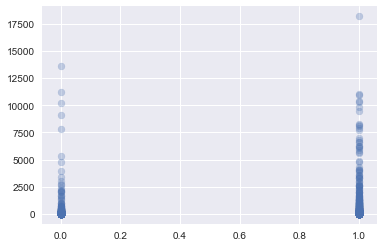

In [65]:
##making charts to see if the number of posts and the number of swedishfish are similar across both users
x=dmerged.insuicide
y=dmerged.siteposts
plt.scatter(x,y,alpha=.3)
plt.xkcd
plt.show()

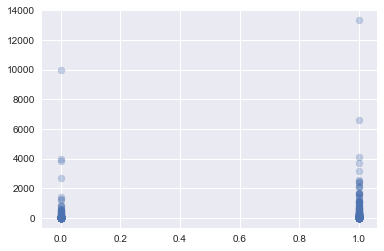

In [66]:
x=dmerged.insuicide
y=dmerged.swedishfish
plt.scatter(x,y,alpha=.3)
plt.show()

In [ ]:
depression.to_csv("/Users/yonilevine/Desktop/Capstone/datasets/depressionnlp.csv")

### Model Building

In [67]:
url="https://www.dropbox.com/s/mkpih20fy6zojq6/depressionnlp%20copy.csv?dl=1"
depression=pd.read_csv(url)

In [68]:
depression.drop('Unnamed: 0',axis=1,inplace=True)

In [69]:
##getting rid of any invalid characters that won't allow my count 
#vectorizer to run
depression['text'] = depression["text"].apply(lambda x:''.join(["" if ord(i) < 32 or ord(i) > 126 else i for i in x]))

In [75]:
def remove_punctuation(s):
    s = ''.join([i for i in s if i not in frozenset(string.punctuation)])
    return s

In [76]:
##using a function to remove punctuation
depression['text'] = depression['text'].apply(remove_punctuation)

In [77]:
def remove_numbers(s):
    s = ''.join([i for i in s if not i.isdigit()])
    return s

In [78]:
##using a function to remove numbers
depression['text'] = depression['text'].apply(remove_numbers)

In [79]:
def lemmatizer_df(df):
    tokenizer = RegexpTokenizer(r'\w+')
    df['tokens'] = [tokenizer.tokenize(story) for story in df['text']] 
    lemmatizer = WordNetLemmatizer()
    lemtext=[]
    for i,item in enumerate(df.tokens):
        x=[lemmatizer.lemmatize(word) for word in item]
        lemtext.append(x)
    df['lemtext']=lemtext
    lemmatized=[]
    for item in df.lemtext:
        lemmatized.append(' '.join(map(str, item)))
    df['text2']=lemmatized
    return df


In [82]:
lemmatizer_df(depression)

username  \
0                        juno2   
1                  timetourist   
2             insearchofpeople   
3             insearchofpeople   
4                     lilyfrog   
5           callherblackmariah   
6                  sensualgirl   
7              lavendernothing   
8             insearchofpeople   
9                always_lonely   
10                 endlesstear   
11            insearchofpeople   
12                        redq   
13                   omniverse   
14                   omniverse   
15                     oldlady   
16                      blkdog   
17                    inth33nd   
18                    wisteria   
19                hiddensmiles   
20                   eric_lost   
21                      lost45   
22                    graymoon   
23                    lilyfrog   
24              wastinglight98   
25                       angie   
26                        bc10   
27                  clementiny   
28                     newwife   
29                 black_sheep   
...                        ...   
17367             shadowaka086   
17368                 jstreba1   
17369                    panga   
17370            punkchiclet88   
17371                    tilly   
17372       beautifullyscarred   
17373                    tilly   
17374               doomfunk12   
17375      distorted_innocence   
17376                    ghost   
17377                    ghost   
17378                    tilly   
17379         disposable_angel   
17380                carpediem   
17381       beautifullyscarred   
17382          unfortunateself   
17383               doomfunk12   
17384            punkchiclet88   
17385                 zetsumei   
17386               silent_cry   
17387                    tilly   
17388                  dreamer   
17389                   mousey   
17390                    tilly   
17391                 zetsumei   
17392  beautifullysuicidal2007   
17393               silent_cry   
17394                    ghost   
17395               doomfunk12   
17396                  crimson   

                                                    text siteposts  \
0      Ive kept my depression and OCD hidden from my ...         7   
1      Ive had clinical depression for a little over ...        36   
2      Yesterday I quit my job of  years This job gav...       268   
3      I got a new roommate A guy who found me on FB ...       268   
4      Ok Had a really bad weekend this weekend gone ...       164   
5      Everyday I see people going about their lives ...         1   
6      All the suffering I went through and now Im fi...      5349   
7      Im a  year olds and Ive been drawing since I w...         2   
8      So I wasnt sure about my new roommate We seem ...       268   
9      Hi I am a good and giving person normally and ...         2   
10     So I want to talk about my life to begin with ...        61   
11     I was trying hard to build a new life for myse...       268   
12     Ive done so much harm in my life Ive slept wit...         2   
13     I am going to express whats on my mind in rega...         4   
14     I am going to express whats on my mind in rega...         4   
15     I belong to a forum where caregivers of loved ...      1631   
16     My parents are coming to visit was the news I ...         2   
17     I used to be a really smart confident hard wor...         1   
18     I just started online therapy to deal with som...         4   
19     The late night demons They plague me They are ...         1   
20     I remembered reading other peoples posts from ...         2   
21     Its been a long time since i last logged in I ...       121   
22     I am completely alone I want to scream I want ...         1   
23     i have a lot going on in life a lot I should b...       164   
24     I started noticing this a few months ago and i...        20   
25     Hi guys Just feeling pretty down today No moti...       574   
26     Ive documented m

In [84]:
##removing any usernames from within the actual text as users
## often sign their name at the end of each post and several users were showing up as features
usernames=depression.username.unique()
depression.text2 = [" ".join([word for word in x.split() if word not in usernames]) for x in depression.text2]

In [85]:
##changing my 2 numeric columns into numeric dtype
depression['swedishfish'] = pd.to_numeric(depression.swedishfish, errors='coerce')
depression['siteposts'] = pd.to_numeric(depression.siteposts, errors='coerce')
depression.fillna(0,inplace=True)

In [86]:
train, test = train_test_split(depression,stratify=depression.insuicide,test_size=.3, random_state=9245)

In [87]:
depression.to_csv(/Users/yonilevine//Users/yonilevine//Desktop/Capstone/datasets/nlp_ready.csv")

In [ ]:
## I ran through a lot of dif types of models here to see which ones I should pursue further or not. I did a tfidf and
##reg count vectorizer for logistic regression, multinomial naive bayes, bernouli nb, random forest, and SVC for a 
#total of ten model. The two best were logistic regression and SVC both with tfidf, which I gridsearched the best parameters
#for later on in my notebook

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', MultinomialNB())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('cls', MultinomialNB())
])  
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('cls', BernoulliNB())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', LogisticRegression())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('cls', LogisticRegression())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', RandomForestClassifier())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('cls', RandomForestClassifier())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('cls', SVC(kernel='linear'))
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', SVC(kernel='linear'))
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('cls', SVC())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('cls', SVC())
]) 
pipeline.fit(train['text2'], train["insuicide"])

pipeline.score(test['text2'], test['insuicide'])

### Final Model Selection
I gridsearched over my two top models to find the best parameters, however I ran this in the cloud and would not recommend running this on your computer it will take a long time. The best parameters for logistic regression models are C=1 and penalty='l2', and the best parameters for the SVC were a linear kernel and C=1. Note that all scores are an roc-auc score.

#### Weighted Logistic Regression Model

In [ ]:
## gridsearching on the best parameters for my two best performing
##models to optimize them further

params={'model__C':[.001,.01,.05,.1,.5,1,5,10],
           'model__penalty':['l1','l2']}
pipelinelrw = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4),lowercase=True,strip_accents='ascii')),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression(class_weight={0:1,1:1.5}))])
gridlrw = GridSearchCV(pipelinelrw, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')

gridlrw.fit(train['text2'], train["insuicide"])

gridlrw.score(test['text2'], test['insuicide'])

In [ ]:
predlrw=gridlrw.predict(test['text2'])
print(classification_report(test['insuicide'], predlrw, labels=[0,1], target_names=['depressive', 'suicidal']))

#### Logistic Regression Model 

In [ ]:

params={'model__C':[.001,.01,.05,.1,.5,1,5,10],
           'model__penalty':['l1','l2']}
pipelinelr = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4),lowercase=True,strip_accents='ascii')),
    ('tfidf', TfidfTransformer()),
    ('model',LogisticRegression(class_weight={0:1,1:1.5}))])
gridlr = GridSearchCV(pipelinelrw, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc')

gridlr.fit(train['text2'], train["insuicide"])

gridlr.score(test['text2'], test['insuicide'])

In [ ]:
predlr=gridlr.predict(test['text2'])
print(classification_report(test['insuicide'], predlr, labels=[0,1], target_names=['depressive', 'suicidal']))

#### SVC

In [ ]:
 
params={'model__C':[.01,.05,.1,1,5],
           'model__kernel':['linear','poly','rbf']}
pipelinesvc = Pipeline([
    ('vect', CountVectorizer(min_df=40,ngram_range=(1,4),lowercase=True,strip_accents='ascii')),
    ('tfidf', TfidfTransformer()),
    ('model',SVC())])
gridsvc = GridSearchCV(pipelinesvc, cv=5, n_jobs=-1, param_grid=params ,scoring='roc_auc',verbose=1)

gridsvc.fit(train['text2'], train['insuicide'])

gridsvc.score(test['text2'], test['insuicide'])


In [ ]:
predsvc=gridsvc.predict(test['text2'])
print(classification_report(test['insuicide'], predlrw, labels=[0,1], target_names=['depressive', 'suicidal']))

Creating confusion matrixes of each logistic regression

In [ ]:
lr_cnf_matrix = confusion_matrix(test['insuicide'], predlr)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['depressive','suicidal'],
                      title='Logistic Regression')

plt.show()

In [ ]:
lrw_cnf_matrix = confusion_matrix(test['insuicide'], predlrw)
np.set_printoptions(precision=2)


plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['depressive','suicidal'],
                      title='Logistic Regression')

plt.show()